# ═══════════════════════════════════════════════════════════════════════════════
# NOTEBOOK 01: EXPLORATORY FACTOR ANALYSIS (EFA)
# ═══════════════════════════════════════════════════════════════════════════════

**Purpose**: Identify latent factor structure for AIRS scale using development sample

**Design Decisions**:
- **Sample**: EFA development sample (N=256)
- **Extraction**: Principal Axis Factoring with oblimin rotation
- **Factor Determination**: Parallel analysis + eigenvalue > 1 + interpretability

**Final Results**:
- ✅ 8-factor solution confirmed (7 UTAUT2 + AI Trust)
- ✅ 16 items retained (2 per construct)
- ✅ All factor loadings ≥ 0.50
- ✅ Simple structure achieved (no cross-loadings > 0.32)

**Key Findings**:
- AI Trust emerges as distinct 8th factor
- Habit and Social Influence strongest constructs
- Clean item-to-factor mapping

**Outputs**:
- Factor loading matrices (pattern & structure)
- Scree plot and parallel analysis
- Item selection recommendations

```mermaid
flowchart TB
    subgraph Phase1["Phase 1: Item Diagnostics"]
        A["📊 24 Items<br/>12 Constructs"] --> B["🔍 Reliability Analysis<br/>Cronbach's α"]
        B --> C["📈 Construct α ≥ 0.70?"]
    end
    
    subgraph Phase2["Phase 2: Exploratory Factor Analysis"]
        D["🧮 Parallel Analysis<br/>& Scree Plot"] --> E["📊 Extract 8 Factors"]
        E --> F["🎯 Loading Pattern<br/>Analysis"]
    end
    
    subgraph Phase3["Phase 3: Final Model"]
        G["✅ 16 Items Retained<br/>2 per construct"]
        H["✅ All λ ≥ 0.50"]
        I["✅ No cross-loadings<br/>> 0.32"]
    end
    
    C --> D
    F --> G
    F --> H
    F --> I
    
    style A fill:#1565c0,color:#fff
    style G fill:#2e7d32,color:#fff
    style H fill:#2e7d32,color:#fff
    style I fill:#2e7d32,color:#fff
```

## 1.1 Environment Setup

In [1]:
import sys
import warnings
import os

# Fix for potential OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from IPython.display import display, Markdown

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

warnings.filterwarnings('ignore')

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

# Plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

POPULATION = 'experiment'  # Experimental analysis excluding full-time students

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Population: {POPULATION.upper()} (excluding full-time students)")

✓ Libraries loaded
✓ Random seed: 67
✓ Population: EXPERIMENT (excluding full-time students)


## 1.2 Load Data and Metadata

In [2]:
# Load DEVELOPMENT sample for EFA (split-sample validation)
# EFA uses AIRS_experiment.csv, CFA uses AIRS_holdout.csv
df_full = pd.read_csv('data/AIRS_experiment.csv')

# Load experiment config to show what was selected
import json as json_config
with open('data/experiment_config.json', 'r') as f:
    exp_config = json_config.load(f)

print("=" * 90)
print("EFA DEVELOPMENT SAMPLE LOADED")
print("=" * 90)
print(f"📊 EFA Sample: N = {len(df_full)} (development for factor exploration)")
print(f"📋 Selected roles: {exp_config['selected_roles']}")
print(f"📋 Roles included: {exp_config['roles_included']}")
print()

# Load item metadata
with open('../data/airs_28item_complete.json', 'r', encoding='utf-8') as f:
    item_metadata = json.load(f)

# Extract structure - ALL items initially
ALL_PREDICTOR_ITEMS = item_metadata['predictor_items']  # 24 items
outcome_items = item_metadata['outcome_items']  # 4 BI items
ALL_CONSTRUCTS = item_metadata['constructs']
metadata = item_metadata['metadata']
positive_items = item_metadata['positive_items']
negative_items = item_metadata['negative_items']

# Create construct mapping dictionary
ALL_PREDICTOR_CONSTRUCTS = {
    'PE': ['PE1', 'PE2'],
    'EE': ['EE1', 'EE2'],
    'SI': ['SI1', 'SI2'],
    'FC': ['FC1', 'FC2'],
    'HM': ['HM1', 'HM2'],
    'PV': ['PV1', 'PV2'],
    'HB': ['HB1', 'HB2'],
    'VO': ['VO1', 'VO2'],
    'TR': ['TR1', 'TR2'],
    'EX': ['EX1', 'EX2'],
    'ER': ['ER1', 'ER2'],
    'AX': ['AX1', 'AX2'],
}

print(f"Sample (excluding FT students): N = {len(df_full)}")
print(f"Total predictor items: {len(ALL_PREDICTOR_ITEMS)}")
print(f"Total constructs: {len(ALL_PREDICTOR_CONSTRUCTS)}")
print(f"\nConstructs: {list(ALL_PREDICTOR_CONSTRUCTS.keys())}")

EFA DEVELOPMENT SAMPLE LOADED
📊 EFA Sample: N = 256 (development for factor exploration)
📋 Selected roles: ['ALL']
📋 Roles included: ['IC', 'Manager', 'PT_Student', 'Other', 'Freelancer', 'FT_Student', 'Executive', 'Unemployed']

Sample (excluding FT students): N = 256
Total predictor items: 24
Total constructs: 12

Constructs: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'VO', 'TR', 'EX', 'ER', 'AX']


## 1.3 Descriptive Statistics - All Items

In [3]:
# Descriptive statistics for ALL items
df_all_items = df_full[ALL_PREDICTOR_ITEMS].copy()

desc_stats = df_all_items.describe().T
desc_stats['skew'] = df_all_items.skew()
desc_stats['kurtosis'] = df_all_items.kurtosis()
desc_stats['construct'] = [metadata[item]['construct_abbr'] for item in desc_stats.index]

# Add item text for reference
desc_stats['item_text'] = [metadata[item]['question_text'][:50] + '...' for item in desc_stats.index]

print("DESCRIPTIVE STATISTICS - ALL 24 PREDICTOR ITEMS")
print("=" * 80)
display(desc_stats[['construct', 'mean', 'std', 'min', 'max', 'skew', 'kurtosis']].round(3))

# Flag potential issues
skew_issues = desc_stats[abs(desc_stats['skew']) > 1.0]
kurt_issues = desc_stats[abs(desc_stats['kurtosis']) > 3.0]

if len(skew_issues) > 0:
    print(f"\n⚠️ Items with |skewness| > 1.0: {list(skew_issues.index)}")
if len(kurt_issues) > 0:
    print(f"⚠️ Items with |kurtosis| > 3.0: {list(kurt_issues.index)}")

DESCRIPTIVE STATISTICS - ALL 24 PREDICTOR ITEMS


,construct,mean,std,min,max,skew,kurtosis
PE1,PE,3.676,1.148,1.0,5.0,-0.907,0.204
PE2,PE,3.402,1.181,1.0,5.0,-0.593,-0.437
EE1,EE,3.789,1.045,1.0,5.0,-0.690,-0.052
EE2,EE,3.602,1.035,1.0,5.0,-0.702,0.015
SI1,SI,3.188,1.129,1.0,5.0,-0.227,-0.596
SI2,SI,3.387,1.090,1.0,5.0,-0.266,-0.625
FC1,FC,3.230,1.187,1.0,5.0,-0.214,-0.963
FC2,FC,3.520,1.013,1.0,5.0,-0.726,0.243
HM1,HM,3.340,1.164,1.0,5.0,-0.374,-0.701
HM2,HM,3.410,1.165,1.0,5.0,-0.591,-0.417



⚠️ Items with |skewness| > 1.0: ['VO2']


## 1.4 Item Reference Guide

Complete item text for informed selection decisions.

In [4]:
# Display full item reference
print("=" * 90)
print("COMPLETE ITEM REFERENCE GUIDE")
print("=" * 90)

for construct, items in ALL_PREDICTOR_CONSTRUCTS.items():
    construct_name = metadata[items[0]]['construct']
    print(f"\n{'─' * 90}")
    print(f"📋 {construct}: {construct_name}")
    print(f"{'─' * 90}")
    for item in items:
        direction = metadata[item]['direction']
        text = metadata[item]['question_text']
        mean_val = df_all_items[item].mean()
        std_val = df_all_items[item].std()
        print(f"  {item} [{direction:8}]: \"{text}\"")
        print(f"           Mean={mean_val:.2f}, SD={std_val:.2f}")

COMPLETE ITEM REFERENCE GUIDE

──────────────────────────────────────────────────────────────────────────────────────────
📋 PE: Performance Expectancy
──────────────────────────────────────────────────────────────────────────────────────────
  PE1 [POSITIVE]: "AI tools help me accomplish tasks more quickly."
           Mean=3.68, SD=1.15
  PE2 [POSITIVE]: "Using AI improves the quality of my work or studies."
           Mean=3.40, SD=1.18

──────────────────────────────────────────────────────────────────────────────────────────
📋 EE: Effort Expectancy
──────────────────────────────────────────────────────────────────────────────────────────
  EE1 [POSITIVE]: "Learning to use AI tools is easy for me."
           Mean=3.79, SD=1.05
  EE2 [POSITIVE]: "Interacting with AI tools is clear and understandable."
           Mean=3.60, SD=1.04

──────────────────────────────────────────────────────────────────────────────────────────
📋 SI: Social Influence
───────────────────────────────────────

## 1.5 Within-Construct Reliability Analysis

In [5]:
# Within-construct analysis functions
def cronbach_alpha(data):
    """Calculate Cronbach's alpha for a set of items."""
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    item_vars = data.var(axis=0, ddof=1)
    total_var = data.sum(axis=1).var(ddof=1)
    return (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)

def item_total_correlation(df, items):
    """Calculate corrected item-total correlations."""
    results = {}
    total = df[items].sum(axis=1)
    for item in items:
        # Corrected: exclude item from total
        corrected_total = total - df[item]
        results[item] = df[item].corr(corrected_total)
    return results

# Analyze each construct
construct_diagnostics = []

print("=" * 90)
print("WITHIN-CONSTRUCT RELIABILITY ANALYSIS - ALL CONSTRUCTS")
print("=" * 90)

for construct, items in ALL_PREDICTOR_CONSTRUCTS.items():
    construct_name = metadata[items[0]]['construct']
    construct_df = df_all_items[items]
    
    # Inter-item correlation
    r = construct_df.corr().iloc[0, 1]
    
    # Cronbach's alpha
    alpha = cronbach_alpha(construct_df)
    
    # Item-total correlations
    itc = item_total_correlation(df_all_items, items)
    
    # Status assessment
    if alpha >= 0.70:
        status = "✓ Good"
    elif alpha >= 0.60:
        status = "~ Marginal"
    else:
        status = "✗ Poor"
    
    construct_diagnostics.append({
        'Construct': construct,
        'Name': construct_name,
        'Items': ', '.join(items),
        'r_inter': r,
        'Alpha': alpha,
        'ITC_1': itc[items[0]],
        'ITC_2': itc[items[1]],
        'Status': status
    })
    
    print(f"\n{construct} ({construct_name}):")
    print(f"  Inter-item r = {r:.3f}")
    print(f"  Cronbach's α = {alpha:.3f} {status}")
    print(f"  {items[0]} ITC = {itc[items[0]]:.3f}")
    print(f"  {items[1]} ITC = {itc[items[1]]:.3f}")

diagnostics_df = pd.DataFrame(construct_diagnostics)

WITHIN-CONSTRUCT RELIABILITY ANALYSIS - ALL CONSTRUCTS

PE (Performance Expectancy):
  Inter-item r = 0.690
  Cronbach's α = 0.816 ✓ Good
  PE1 ITC = 0.690
  PE2 ITC = 0.690

EE (Effort Expectancy):
  Inter-item r = 0.679
  Cronbach's α = 0.809 ✓ Good
  EE1 ITC = 0.679
  EE2 ITC = 0.679

SI (Social Influence):
  Inter-item r = 0.610
  Cronbach's α = 0.758 ✓ Good
  SI1 ITC = 0.610
  SI2 ITC = 0.610

FC (Facilitating Conditions):
  Inter-item r = 0.630
  Cronbach's α = 0.767 ✓ Good
  FC1 ITC = 0.630
  FC2 ITC = 0.630

HM (Hedonic Motivation):
  Inter-item r = 0.776
  Cronbach's α = 0.874 ✓ Good
  HM1 ITC = 0.776
  HM2 ITC = 0.776

PV (Price Value):
  Inter-item r = 0.757
  Cronbach's α = 0.861 ✓ Good
  PV1 ITC = 0.757
  PV2 ITC = 0.757

HB (Habit):
  Inter-item r = 0.816
  Cronbach's α = 0.899 ✓ Good
  HB1 ITC = 0.816
  HB2 ITC = 0.816

VO (Voluntariness):
  Inter-item r = 0.246
  Cronbach's α = 0.391 ✗ Poor
  VO1 ITC = 0.246
  VO2 ITC = 0.246

TR (Trust in AI):
  Inter-item r = 0.826
  

In [6]:
# Summary table
print("\n" + "=" * 90)
print("CONSTRUCT RELIABILITY SUMMARY")
print("=" * 90)

display(diagnostics_df[['Construct', 'Name', 'r_inter', 'Alpha', 'ITC_1', 'ITC_2', 'Status']].round(3))

# Classification counts
good = len(diagnostics_df[diagnostics_df['Alpha'] >= 0.70])
marginal = len(diagnostics_df[(diagnostics_df['Alpha'] >= 0.60) & (diagnostics_df['Alpha'] < 0.70)])
poor = len(diagnostics_df[diagnostics_df['Alpha'] < 0.60])

print(f"\n✓ Good reliability (α ≥ .70): {good}/12 constructs")
print(f"~ Marginal reliability (.60 ≤ α < .70): {marginal}/12 constructs")
print(f"✗ Poor reliability (α < .60): {poor}/12 constructs")


CONSTRUCT RELIABILITY SUMMARY


,Construct,Name,r_inter,Alpha,ITC_1,ITC_2,Status
0,PE,Performance Expectancy,0.690,0.816,0.690,0.690,✓ Good
1,EE,Effort Expectancy,0.679,0.809,0.679,0.679,✓ Good
2,SI,Social Influence,0.610,0.758,0.610,0.610,✓ Good
3,FC,Facilitating Conditions,0.630,0.767,0.630,0.630,✓ Good
4,HM,Hedonic Motivation,0.776,0.874,0.776,0.776,✓ Good
5,PV,Price Value,0.757,0.861,0.757,0.757,✓ Good
6,HB,Habit,0.816,0.899,0.816,0.816,✓ Good
7,VO,Voluntariness,0.246,0.391,0.246,0.246,✗ Poor
8,TR,Trust in AI,0.826,0.904,0.826,0.826,✓ Good
9,EX,Explainability,0.383,0.545,0.383,0.383,✗ Poor



✓ Good reliability (α ≥ .70): 8/12 constructs
~ Marginal reliability (.60 ≤ α < .70): 0/12 constructs
✗ Poor reliability (α < .60): 4/12 constructs


## 1.6 Within-Construct Correlation Heatmap

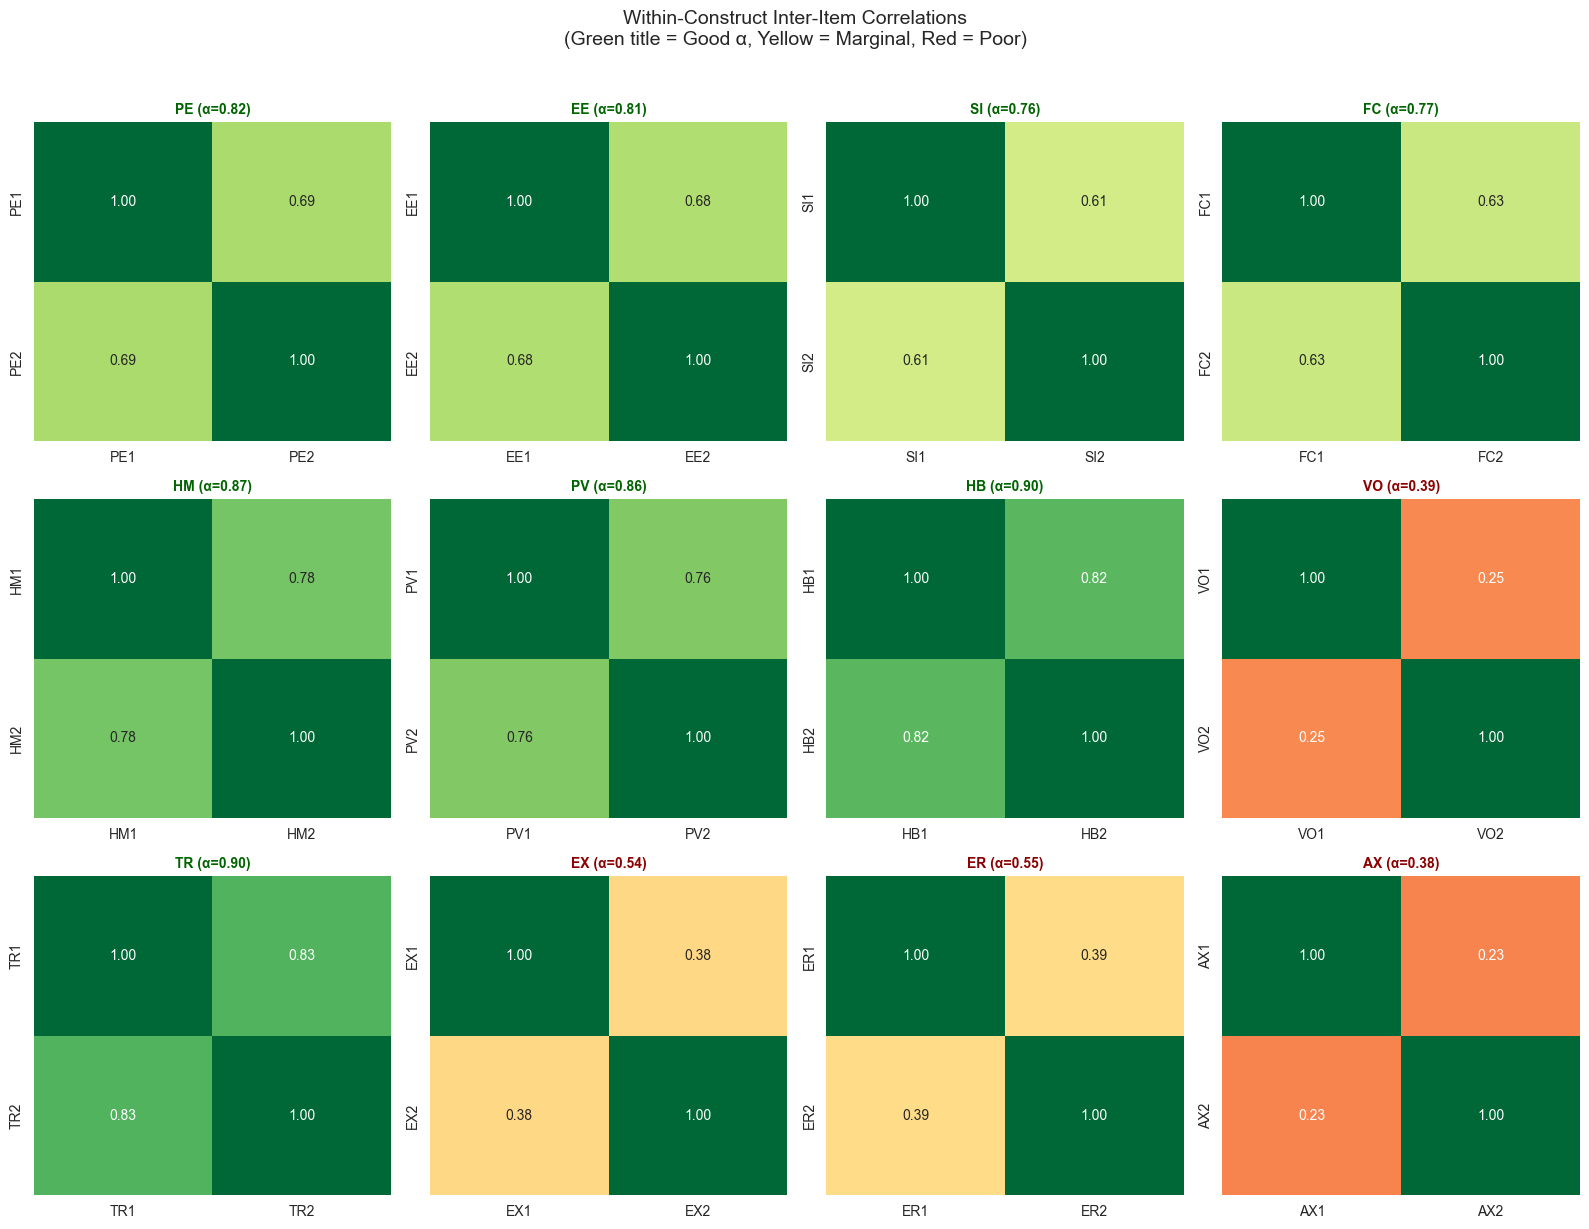

In [7]:
# Heatmap visualization
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, (construct, items) in enumerate(ALL_PREDICTOR_CONSTRUCTS.items()):
    ax = axes[idx]
    construct_df = df_all_items[items]
    corr = construct_df.corr()
    
    alpha_val = diagnostics_df[diagnostics_df['Construct'] == construct]['Alpha'].values[0]
    status = diagnostics_df[diagnostics_df['Construct'] == construct]['Status'].values[0]
    
    color = 'darkgreen' if 'Good' in status else ('goldenrod' if 'Marginal' in status else 'darkred')
    
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
               vmin=0, vmax=1, ax=ax, cbar=False,
               xticklabels=items, yticklabels=items)
    ax.set_title(f"{construct} (α={alpha_val:.2f})", fontsize=10, color=color, fontweight='bold')

plt.suptitle('Within-Construct Inter-Item Correlations\n(Green title = Good α, Yellow = Marginal, Red = Poor)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/phase1_within_construct_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.7 Item-Level Diagnostics Summary

In [8]:
# Create comprehensive item diagnostics
item_diagnostics = []

for item in ALL_PREDICTOR_ITEMS:
    construct = metadata[item]['construct_abbr']
    direction = metadata[item]['direction']
    
    # Find ITC from construct analysis
    construct_items = ALL_PREDICTOR_CONSTRUCTS[construct]
    itc_dict = item_total_correlation(df_all_items, construct_items)
    
    # Item stats
    mean_val = df_all_items[item].mean()
    std_val = df_all_items[item].std()
    skew_val = df_all_items[item].skew()
    kurt_val = df_all_items[item].kurtosis()
    
    # Flags
    issues = []
    if abs(skew_val) > 1.0:
        issues.append('SKEW')
    if abs(kurt_val) > 3.0:
        issues.append('KURT')
    if itc_dict[item] < 0.30:
        issues.append('LOW_ITC')
    
    item_diagnostics.append({
        'Item': item,
        'Construct': construct,
        'Direction': direction,
        'Mean': mean_val,
        'SD': std_val,
        'Skew': skew_val,
        'Kurt': kurt_val,
        'ITC': itc_dict[item],
        'Issues': ', '.join(issues) if issues else '✓'
    })

item_diag_df = pd.DataFrame(item_diagnostics)

print("=" * 90)
print("ITEM-LEVEL DIAGNOSTICS SUMMARY")
print("=" * 90)
display(item_diag_df.round(3))

# Flag problem items
problem_items = item_diag_df[item_diag_df['Issues'] != '✓']
if len(problem_items) > 0:
    print(f"\n⚠️ ITEMS WITH POTENTIAL ISSUES ({len(problem_items)}):")
    for _, row in problem_items.iterrows():
        print(f"   {row['Item']} ({row['Construct']}): {row['Issues']}")
else:
    print("\n✓ All items pass basic diagnostics")

ITEM-LEVEL DIAGNOSTICS SUMMARY


,Item,Construct,Direction,Mean,SD,Skew,Kurt,ITC,Issues
0,PE1,PE,POSITIVE,3.676,1.148,-0.907,0.204,0.690,✓
1,PE2,PE,POSITIVE,3.402,1.181,-0.593,-0.437,0.690,✓
2,EE1,EE,POSITIVE,3.789,1.045,-0.690,-0.052,0.679,✓
3,EE2,EE,POSITIVE,3.602,1.035,-0.702,0.015,0.679,✓
4,SI1,SI,POSITIVE,3.188,1.129,-0.227,-0.596,0.610,✓
5,SI2,SI,POSITIVE,3.387,1.090,-0.266,-0.625,0.610,✓
6,FC1,FC,POSITIVE,3.230,1.187,-0.214,-0.963,0.630,✓
7,FC2,FC,POSITIVE,3.520,1.013,-0.726,0.243,0.630,✓
8,HM1,HM,POSITIVE,3.340,1.164,-0.374,-0.701,0.776,✓
9,HM2,HM,POSITIVE,3.410,1.165,-0.591,-0.417,0.776,✓



⚠️ ITEMS WITH POTENTIAL ISSUES (4):
   VO1 (VO): LOW_ITC
   VO2 (VO): SKEW, LOW_ITC
   AX1 (AX): LOW_ITC
   AX2 (AX): LOW_ITC


## 1.8 KMO and Bartlett's Test (All Items)

In [9]:
# KMO and Bartlett's on ALL items
kmo_all, kmo_model = calculate_kmo(df_all_items)
chi_square, p_value = calculate_bartlett_sphericity(df_all_items)

print("=" * 90)
print("FACTORABILITY ASSESSMENT - ALL 24 ITEMS")
print("=" * 90)

print(f"\nKMO Measure of Sampling Adequacy: {kmo_model:.3f}")
if kmo_model >= 0.90:
    kmo_interpretation = "Marvelous"
elif kmo_model >= 0.80:
    kmo_interpretation = "Meritorious"
elif kmo_model >= 0.70:
    kmo_interpretation = "Middling"
elif kmo_model >= 0.60:
    kmo_interpretation = "Mediocre"
elif kmo_model >= 0.50:
    kmo_interpretation = "Miserable"
else:
    kmo_interpretation = "Unacceptable"
print(f"  Interpretation: {kmo_interpretation} (Kaiser, 1974)")

print(f"\nBartlett's Test of Sphericity:")
print(f"  Chi-square: {chi_square:.2f}")
print(f"  p-value: {p_value:.2e}")
print(f"  Result: {'✓ Significant' if p_value < 0.001 else '✗ Not significant'}")

# Item-level KMO
print(f"\nItem-level KMO (flagged if < 0.50):")
low_kmo_items = [(ALL_PREDICTOR_ITEMS[i], kmo_all[i]) for i in range(len(ALL_PREDICTOR_ITEMS)) if kmo_all[i] < 0.50]
if low_kmo_items:
    for item, kmo in low_kmo_items:
        print(f"  ⚠️ {item}: {kmo:.3f}")
else:
    print("  ✓ All items have KMO ≥ 0.50")

FACTORABILITY ASSESSMENT - ALL 24 ITEMS

KMO Measure of Sampling Adequacy: 0.929
  Interpretation: Marvelous (Kaiser, 1974)

Bartlett's Test of Sphericity:
  Chi-square: 4121.35
  p-value: 0.00e+00
  Result: ✓ Significant

Item-level KMO (flagged if < 0.50):
  ✓ All items have KMO ≥ 0.50


## 1.9 Communalities Analysis

Communalities indicate how much variance in each item is explained by the factors. Low communalities (< 0.40) suggest items that may not contribute meaningfully to the factor structure.

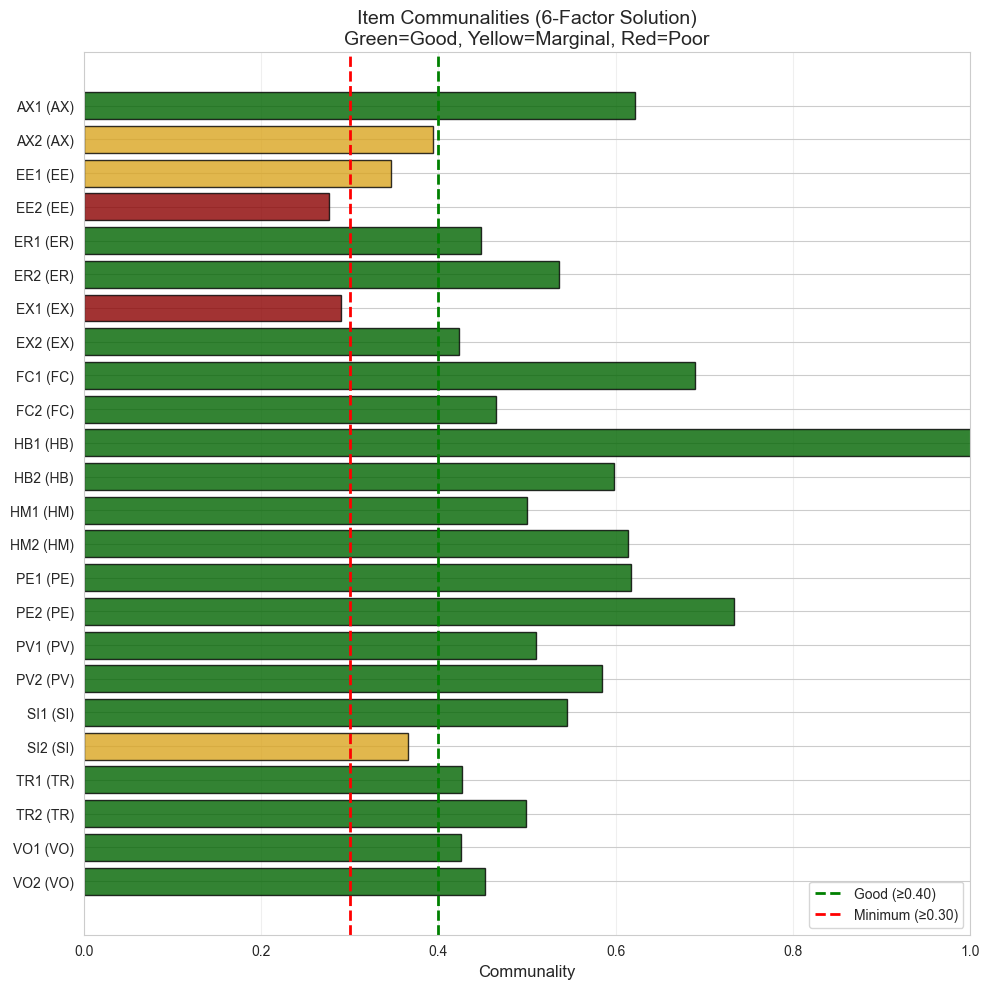


📊 Communality Summary:
   Good (≥ 0.40): 19 items
   Marginal (0.30-0.40): 3 items
   Poor (< 0.30): 2 items

⚠️ Items with LOW communalities (consider dropping):
   EX1 (EX): 0.291
   EE2 (EE): 0.276


In [10]:
# Communalities analysis - fit EFA to get communalities
fa_comm = FactorAnalyzer(n_factors=6, rotation='promax', method='minres')
fa_comm.fit(df_all_items)
communalities = pd.Series(fa_comm.get_communalities(), index=ALL_PREDICTOR_ITEMS)

# Add construct info
comm_df = pd.DataFrame({
    'Item': ALL_PREDICTOR_ITEMS,
    'Communality': communalities.values,
    'Construct': [metadata[item]['construct_abbr'] for item in ALL_PREDICTOR_ITEMS]
})
comm_df = comm_df.sort_values('Item', ascending=False)  # Sort by item name alphabetically descending

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['darkred' if c < 0.30 else 'goldenrod' if c < 0.40 else 'darkgreen' 
          for c in comm_df['Communality']]

bars = ax.barh(range(len(comm_df)), comm_df['Communality'], color=colors, edgecolor='black', alpha=0.8)

# Add item labels with construct
ax.set_yticks(range(len(comm_df)))
ax.set_yticklabels([f"{row['Item']} ({row['Construct']})" for _, row in comm_df.iterrows()])

# Reference lines
ax.axvline(x=0.40, color='green', linestyle='--', linewidth=2, label='Good (≥0.40)')
ax.axvline(x=0.30, color='red', linestyle='--', linewidth=2, label='Minimum (≥0.30)')

ax.set_xlabel('Communality', fontsize=12)
ax.set_title('Item Communalities (6-Factor Solution)\nGreen=Good, Yellow=Marginal, Red=Poor', fontsize=14)
ax.legend(loc='lower right')
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/phase1_communalities.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
low_comm = comm_df[comm_df['Communality'] < 0.30]
marginal_comm = comm_df[(comm_df['Communality'] >= 0.30) & (comm_df['Communality'] < 0.40)]
good_comm = comm_df[comm_df['Communality'] >= 0.40]

print(f"\n📊 Communality Summary:")
print(f"   Good (≥ 0.40): {len(good_comm)} items")
print(f"   Marginal (0.30-0.40): {len(marginal_comm)} items")
print(f"   Poor (< 0.30): {len(low_comm)} items")

if len(low_comm) > 0:
    print(f"\n⚠️ Items with LOW communalities (consider dropping):")
    for _, row in low_comm.iterrows():
        print(f"   {row['Item']} ({row['Construct']}): {row['Communality']:.3f}")

# ═══════════════════════════════════════════════════════════════════════════════
# PREPARE DATA FOR EFA
# ═══════════════════════════════════════════════════════════════════════════════

All 24 predictor items are included in EFA. **Best practice**: Let EFA reveal the factor structure without preconceptions. Item selection happens at the CFA stage based on EFA findings.

In [11]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║  PREPARE DATA FOR EFA - All 24 Items                                         ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

# Use ALL 24 predictor items - let EFA reveal structure, cherry-pick at CFA
SELECTED_ITEMS = ALL_PREDICTOR_ITEMS.copy()

# Build construct dictionary
selected_predictor_constructs = {}
for item in SELECTED_ITEMS:
    construct = item[:-1]  # Remove number suffix (e.g., 'PE1' -> 'PE')
    if construct not in selected_predictor_constructs:
        selected_predictor_constructs[construct] = []
    selected_predictor_constructs[construct].append(item)

# Create EFA dataframe
df_efa = df_full[SELECTED_ITEMS].copy()

# Update global references
predictor_items = SELECTED_ITEMS.copy()
predictor_constructs = selected_predictor_constructs

print("=" * 70)
print("EFA DATA PREPARATION")
print("=" * 70)
print(f"\n📊 Items: {len(SELECTED_ITEMS)}/24 (all predictor items)")
print(f"   Constructs: {len(selected_predictor_constructs)}/12")
print(f"\n✓ df_efa ready: {df_efa.shape[0]} observations × {df_efa.shape[1]} items")

EFA DATA PREPARATION

📊 Items: 24/24 (all predictor items)
   Constructs: 12/12

✓ df_efa ready: 256 observations × 24 items


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 2: FACTOR EXPLORATION
# ═══════════════════════════════════════════════════════════════════════════════

## 2.1 Parallel Analysis & Kaiser Criterion

In [12]:
# Eigenvalue analysis
fa_eigen = FactorAnalyzer(rotation=None, n_factors=len(predictor_items))
fa_eigen.fit(df_efa)
ev, v = fa_eigen.get_eigenvalues()

# Parallel analysis
from factor_analyzer.factor_analyzer import calculate_kmo

def parallel_analysis(data, n_iterations=100, percentile=95):
    """Perform parallel analysis to determine number of factors."""
    n_obs, n_vars = data.shape
    random_eigenvalues = np.zeros((n_iterations, n_vars))
    
    for i in range(n_iterations):
        random_data = np.random.normal(size=(n_obs, n_vars))
        random_corr = np.corrcoef(random_data, rowvar=False)
        random_eigenvalues[i] = np.linalg.eigvalsh(random_corr)[::-1]
    
    return np.percentile(random_eigenvalues, percentile, axis=0)

random_ev = parallel_analysis(df_efa.values)

# Determine factors by different criteria
n_factors_kaiser = sum(ev > 1)
n_factors_pa = sum(ev > random_ev)

print("=" * 90)
print("FACTOR EXTRACTION CRITERIA")
print("=" * 90)

print(f"\n{'Factor':<8} {'Eigenvalue':<12} {'Random EV':<12} {'Kaiser':<10} {'PA':<10}")
print("-" * 60)
for i in range(min(12, len(ev))):
    kaiser = "✓" if ev[i] > 1 else ""
    pa = "✓" if ev[i] > random_ev[i] else ""
    print(f"F{i+1:<7} {ev[i]:<12.3f} {random_ev[i]:<12.3f} {kaiser:<10} {pa:<10}")

print(f"\n📊 Recommendations:")
print(f"   Kaiser criterion (λ > 1): {n_factors_kaiser} factors")
print(f"   Parallel analysis: {n_factors_pa} factors")

FACTOR EXTRACTION CRITERIA

Factor   Eigenvalue   Random EV    Kaiser     PA        
------------------------------------------------------------
F1       10.873       1.700        ✓          ✓         
F2       2.196        1.579        ✓          ✓         
F3       1.529        1.490        ✓          ✓         
F4       1.067        1.420        ✓                    
F5       0.874        1.355                             
F6       0.768        1.302                             
F7       0.716        1.248                             
F8       0.623        1.198                             
F9       0.578        1.156                             
F10      0.559        1.108                             
F11      0.520        1.064                             
F12      0.502        1.020                             

📊 Recommendations:
   Kaiser criterion (λ > 1): 4 factors
   Parallel analysis: 3 factors


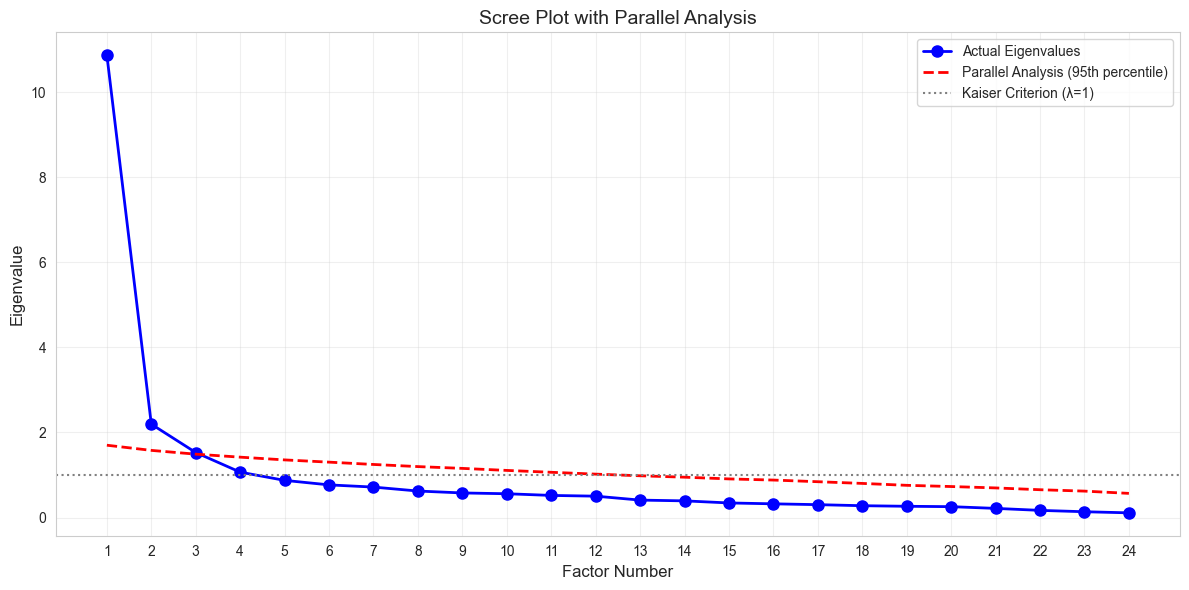

✓ Scree plot saved


In [13]:
# Scree plot with parallel analysis
fig, ax = plt.subplots(figsize=(12, 6))

x = range(1, len(ev) + 1)
ax.plot(x, ev, 'bo-', linewidth=2, markersize=8, label='Actual Eigenvalues')
ax.plot(x, random_ev, 'r--', linewidth=2, label='Parallel Analysis (95th percentile)')
ax.axhline(y=1, color='gray', linestyle=':', label='Kaiser Criterion (λ=1)')

ax.set_xlabel('Factor Number', fontsize=12)
ax.set_ylabel('Eigenvalue', fontsize=12)
ax.set_title('Scree Plot with Parallel Analysis', fontsize=14)
ax.legend()
ax.set_xticks(range(1, len(ev) + 1))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/phase2_scree_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Scree plot saved")

## 2.2 Full Factor Solution (All Possible Factors)

Exploring ALL factors to identify which have meaningful loadings, regardless of eigenvalue.

In [14]:
# Fit maximum factors (up to 12 or number of items)
n_factors_max = min(12, len(predictor_items))

print(f"Fitting EFA with {n_factors_max} factors (maximum exploration)")
print(f"  Estimator: MINRES")
print(f"  Rotation: Promax (oblique)")

efa_full = FactorAnalyzer(n_factors=n_factors_max, rotation='promax', method='minres')
efa_full.fit(df_efa)

# Get variance explained
var_full = efa_full.get_factor_variance()
eigenvalues_full = var_full[0]
prop_var_full = var_full[1]
cum_var_full = var_full[2]

print(f"\n{'Factor':<8} {'SS Loading':<12} {'% Variance':<12} {'Cumulative %':<12} {'Strength':<15}")
print("-" * 70)
for i in range(n_factors_max):
    if eigenvalues_full[i] >= 1.0:
        strength = "★★★ Strong"
    elif eigenvalues_full[i] >= 0.5:
        strength = "★★ Moderate"
    elif eigenvalues_full[i] >= 0.3:
        strength = "★ Weak"
    else:
        strength = "✗ Minimal"
    print(f"F{i+1:<7} {eigenvalues_full[i]:<12.3f} {prop_var_full[i]*100:<12.1f} {cum_var_full[i]*100:<12.1f} {strength}")

print(f"\nTotal variance explained: {cum_var_full[-1]*100:.1f}%")

Fitting EFA with 12 factors (maximum exploration)
  Estimator: MINRES
  Rotation: Promax (oblique)

Factor   SS Loading   % Variance   Cumulative % Strength       
----------------------------------------------------------------------
F1       3.940        16.4         16.4         ★★★ Strong
F2       1.750        7.3          23.7         ★★★ Strong
F3       1.622        6.8          30.5         ★★★ Strong
F4       1.558        6.5          37.0         ★★★ Strong
F5       1.398        5.8          42.8         ★★★ Strong
F6       1.142        4.8          47.5         ★★★ Strong
F7       1.051        4.4          51.9         ★★★ Strong
F8       1.002        4.2          56.1         ★★★ Strong
F9       0.931        3.9          60.0         ★★ Moderate
F10      0.712        3.0          62.9         ★★ Moderate
F11      0.631        2.6          65.6         ★★ Moderate
F12      0.621        2.6          68.2         ★★ Moderate

Total variance explained: 68.2%


## 2.3 Full Pattern Matrix

In [15]:
# Pattern matrix
loadings_full = pd.DataFrame(
    efa_full.loadings_,
    index=predictor_items,
    columns=[f'F{i+1}' for i in range(n_factors_max)]
)

# Add construct labels
loadings_full['Construct'] = [metadata[item]['construct_abbr'] for item in loadings_full.index]

# Highlighting function
def highlight_loadings(val):
    if abs(val) >= 0.50:
        return 'background-color: darkgreen; color: white; font-weight: bold'
    elif abs(val) >= 0.32:
        return 'background-color: goldenrod; color: white'
    return ''

print("FULL PATTERN MATRIX")
print("Green ≥ 0.50 (strong), Yellow ≥ 0.32 (moderate)")
print("=" * 90)

factor_cols = [f'F{i+1}' for i in range(n_factors_max)]
styled = loadings_full[factor_cols + ['Construct']].style.applymap(
    highlight_loadings, subset=factor_cols
).format('{:.3f}', subset=factor_cols)
display(styled)

FULL PATTERN MATRIX
Green ≥ 0.50 (strong), Yellow ≥ 0.32 (moderate)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,Construct
PE1,1.000,0.073,-0.354,0.049,0.011,0.037,0.109,-0.056,0.112,-0.043,-0.010,0.100,PE
PE2,0.858,-0.025,-0.175,0.076,-0.053,0.042,0.098,0.266,0.071,-0.195,-0.110,0.007,PE
EE1,0.126,-0.021,0.182,-0.000,0.003,-0.028,-0.040,-0.012,0.734,0.031,-0.000,0.024,EE
EE2,0.014,0.083,0.090,-0.058,0.049,0.009,0.009,-0.000,0.560,0.160,0.052,-0.116,EE
SI1,-0.002,-0.089,0.010,-0.063,0.028,0.030,0.676,0.063,0.030,0.111,0.106,-0.286,SI
SI2,0.205,0.034,0.131,-0.014,-0.006,-0.080,0.680,-0.094,-0.049,-0.020,-0.006,0.106,SI
FC1,-0.107,0.132,0.478,0.123,0.056,0.291,0.173,-0.054,0.040,-0.101,-0.138,0.005,FC
FC2,0.129,-0.041,-0.098,-0.101,-0.041,1.015,-0.045,0.001,-0.017,0.066,0.100,0.008,FC
HM1,0.248,0.019,0.260,-0.024,-0.038,0.003,0.157,0.324,-0.074,0.018,0.021,-0.024,HM
HM2,0.158,0.056,-0.021,-0.008,0.065,-0.010,-0.063,0.879,-0.004,0.074,0.015,0.107,HM


## 2.4 Factor Quality Assessment

In [16]:
# Analyze each factor's quality
print("=" * 90)
print("FACTOR QUALITY ANALYSIS (by loading strength)")
print("=" * 90)

factor_quality = []

for i in range(n_factors_max):
    factor_name = f'F{i+1}'
    factor_loadings = loadings_full[factor_name]
    abs_loadings = factor_loadings.abs()
    
    # Count items by loading strength
    strong_items = loadings_full[abs_loadings >= 0.50].index.tolist()
    moderate_items = loadings_full[(abs_loadings >= 0.32) & (abs_loadings < 0.50)].index.tolist()
    
    # Check cross-loading issues
    cross_loading_issues = []
    for item in strong_items:
        other_factors = [f'F{j+1}' for j in range(n_factors_max) if j != i]
        other_loadings = loadings_full.loc[item, other_factors].abs()
        if other_loadings.max() >= 0.32:
            cross_factor = other_loadings.idxmax()
            cross_loading_issues.append(f"{item}→{cross_factor}")
    
    # Get constructs loading on this factor
    constructs = [metadata[item]['construct_abbr'] for item in strong_items]
    unique_constructs = list(set(constructs))
    
    # Quality rating
    if len(strong_items) >= 2 and len(cross_loading_issues) == 0:
        quality = "★★★ RETAIN (clean, multi-item)"
    elif len(strong_items) >= 2:
        quality = "★★ RETAIN (minor cross-loading)"
    elif len(strong_items) == 1 and len(cross_loading_issues) == 0:
        quality = "★ CONSIDER (single-item, clean)"
    else:
        quality = "✗ SKIP"
    
    factor_quality.append({
        'Factor': factor_name,
        'Eigenvalue': eigenvalues_full[i],
        'Strong_Items': len(strong_items),
        'Cross_Loadings': len(cross_loading_issues),
        'Constructs': unique_constructs,
        'Quality': quality
    })
    
    print(f"\n{factor_name} (λ={eigenvalues_full[i]:.2f}): {quality}")
    if strong_items:
        print(f"   Strong items: {', '.join(strong_items)}")
        print(f"   Constructs: {', '.join(unique_constructs)}")
    if cross_loading_issues:
        print(f"   ⚠️ Cross-loadings: {', '.join(cross_loading_issues)}")

quality_df = pd.DataFrame(factor_quality)

FACTOR QUALITY ANALYSIS (by loading strength)

F1 (λ=3.94): ★★ RETAIN (minor cross-loading)
   Strong items: PE1, PE2, PV1, PV2, VO1
   Constructs: PE, PV, VO
   ⚠️ Cross-loadings: PE1→F3

F2 (λ=1.75): ★★★ RETAIN (clean, multi-item)
   Strong items: TR1, TR2
   Constructs: TR

F3 (λ=1.62): ★ CONSIDER (single-item, clean)
   Strong items: EX1
   Constructs: EX

F4 (λ=1.56): ★★★ RETAIN (clean, multi-item)
   Strong items: ER1, ER2, AX1
   Constructs: AX, ER

F5 (λ=1.40): ★★★ RETAIN (clean, multi-item)
   Strong items: HB1, HB2
   Constructs: HB

F6 (λ=1.14): ★ CONSIDER (single-item, clean)
   Strong items: FC2
   Constructs: FC

F7 (λ=1.05): ★★★ RETAIN (clean, multi-item)
   Strong items: SI1, SI2
   Constructs: SI

F8 (λ=1.00): ★ CONSIDER (single-item, clean)
   Strong items: HM2
   Constructs: HM

F9 (λ=0.93): ★★★ RETAIN (clean, multi-item)
   Strong items: EE1, EE2
   Constructs: EE

F10 (λ=0.71): ★ CONSIDER (single-item, clean)
   Strong items: VO2
   Constructs: VO

F11 (λ=0.63): ★ 

In [17]:
# Factor quality summary table
print("\n" + "=" * 90)
print("FACTOR QUALITY SUMMARY TABLE")
print("=" * 90)

display(quality_df)

# Recommendations
retain_factors = quality_df[quality_df['Quality'].str.contains('RETAIN')]
consider_factors = quality_df[quality_df['Quality'].str.contains('CONSIDER')]

print(f"\n📊 Factor Recommendations:")
print(f"   ★★★/★★ RETAIN: {len(retain_factors)} factors - {list(retain_factors['Factor'])}")
print(f"   ★ CONSIDER: {len(consider_factors)} factors - {list(consider_factors['Factor'])}")


FACTOR QUALITY SUMMARY TABLE


,Factor,Eigenvalue,Strong_Items,Cross_Loadings,Constructs,Quality
0,F1,3.940121,5,1,"[PE, PV, VO]",★★ RETAIN (minor cross-loading)
1,F2,1.749708,2,0,[TR],"★★★ RETAIN (clean, multi-item)"
2,F3,1.622357,1,0,[EX],"★ CONSIDER (single-item, clean)"
3,F4,1.557864,3,0,"[AX, ER]","★★★ RETAIN (clean, multi-item)"
4,F5,1.397516,2,0,[HB],"★★★ RETAIN (clean, multi-item)"
5,F6,1.142055,1,0,[FC],"★ CONSIDER (single-item, clean)"
6,F7,1.050677,2,0,[SI],"★★★ RETAIN (clean, multi-item)"
7,F8,1.001620,1,0,[HM],"★ CONSIDER (single-item, clean)"
8,F9,0.930631,2,0,[EE],"★★★ RETAIN (clean, multi-item)"
9,F10,0.711787,1,0,[VO],"★ CONSIDER (single-item, clean)"



📊 Factor Recommendations:
   ★★★/★★ RETAIN: 6 factors - ['F1', 'F2', 'F4', 'F5', 'F7', 'F9']
   ★ CONSIDER: 5 factors - ['F3', 'F6', 'F8', 'F10', 'F11']


## 2.5 Cross-Loading Visualization

Items loading substantially (≥ 0.32) on multiple factors create interpretation challenges. This visualization identifies problematic cross-loaders to inform factor selection decisions.

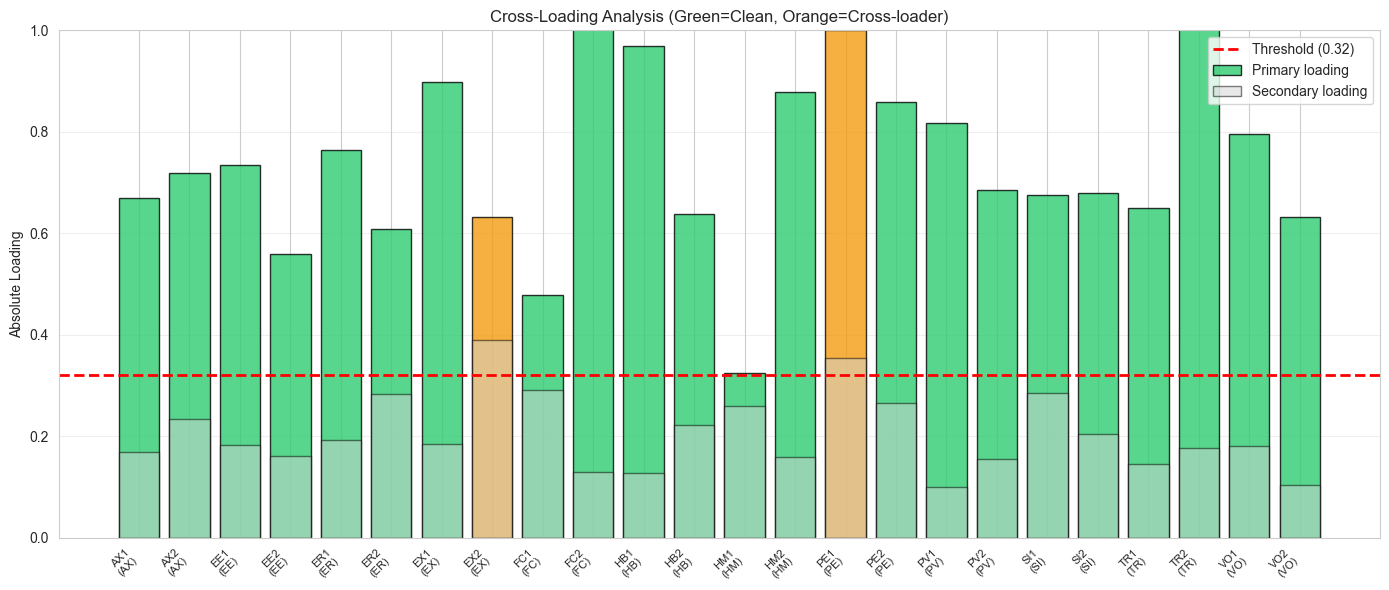

📊 Cross-Loading Summary:
   Clean items: 22/24
   Cross-loaders: 2/24

⚠️ Cross-loading items:


,Item,Construct,Primary,Primary_Loading,Cross_Factors
0,PE1,PE,F1,1.000,F3(-0.35)
1,EX2,EX,F12,0.632,"F1(+0.33), F3(+0.39)"


In [18]:
# Cross-loading analysis (simplified)
cross_loading_threshold = 0.32

# Factor columns only (exclude 'Construct' column)
factor_cols = [f'F{i+1}' for i in range(n_factors_max)]

# Identify cross-loading items
cross_loaders = []
for item in predictor_items:
    item_loadings = loadings_full.loc[item, factor_cols].abs()
    significant = item_loadings[item_loadings >= cross_loading_threshold]
    
    if len(significant) > 1:
        primary = item_loadings.idxmax()
        secondary_factors = [f for f in significant.index if f != primary]
        cross_loaders.append({
            'Item': item,
            'Construct': metadata[item]['construct_abbr'],
            'Primary': primary,
            'Primary_Loading': loadings_full.loc[item, primary],
            'Cross_Factors': ', '.join([f"{f}({loadings_full.loc[item, f]:+.2f})" for f in secondary_factors])
        })

cross_df = pd.DataFrame(cross_loaders)

# Simple bar chart: primary vs secondary loadings
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data
items_sorted = sorted(predictor_items, key=lambda x: (metadata[x]['construct_abbr'], x))
x = np.arange(len(items_sorted))

primary_loads = [loadings_full.loc[item, factor_cols].abs().max() for item in items_sorted]
secondary_loads = [sorted(loadings_full.loc[item, factor_cols].abs(), reverse=True)[1] if len(factor_cols) > 1 else 0 
                   for item in items_sorted]

# Colors: green if clean, orange if cross-loading
cross_items = set(cross_df['Item']) if len(cross_df) > 0 else set()
colors = ['#2ecc71' if item not in cross_items else '#f39c12' for item in items_sorted]

ax.bar(x, primary_loads, color=colors, edgecolor='black', alpha=0.8, label='Primary loading')
ax.bar(x, secondary_loads, color='lightgray', edgecolor='black', alpha=0.5, label='Secondary loading')
ax.axhline(y=cross_loading_threshold, color='red', linestyle='--', lw=2, label=f'Threshold ({cross_loading_threshold})')

ax.set_xticks(x)
ax.set_xticklabels([f"{item}\n({metadata[item]['construct_abbr']})" for item in items_sorted], 
                   rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Absolute Loading')
ax.set_title('Cross-Loading Analysis (Green=Clean, Orange=Cross-loader)')
ax.set_ylim(0, 1)
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/phase2_cross_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print(f"📊 Cross-Loading Summary:")
print(f"   Clean items: {len(predictor_items) - len(cross_df)}/{len(predictor_items)}")
print(f"   Cross-loaders: {len(cross_df)}/{len(predictor_items)}")

if len(cross_df) > 0:
    print(f"\n⚠️ Cross-loading items:")
    display(cross_df[['Item', 'Construct', 'Primary', 'Primary_Loading', 'Cross_Factors']].round(3))

## 2.5 Construct-to-Factor Mapping

In [19]:
# Show which factors each construct's items load on
print("=" * 90)
print("CONSTRUCT-TO-FACTOR MAPPING")
print("=" * 90)
print("Where do items from each theoretical construct load?")

for construct in loadings_full['Construct'].unique():
    construct_items = loadings_full[loadings_full['Construct'] == construct]
    print(f"\n{construct}:")
    for item in construct_items.index:
        item_loadings = loadings_full.loc[item, factor_cols]
        max_factor = item_loadings.abs().idxmax()
        max_loading = item_loadings[max_factor]
        
        # Find any cross-loadings
        sorted_loadings = item_loadings.abs().sort_values(ascending=False)
        secondary = sorted_loadings.index[1] if len(sorted_loadings) > 1 else None
        secondary_loading = item_loadings[secondary] if secondary else 0
        
        cross = f" (also {secondary}: {secondary_loading:+.2f})" if abs(secondary_loading) >= 0.32 else ""
        print(f"   {item} → {max_factor} ({max_loading:+.3f}){cross}")

CONSTRUCT-TO-FACTOR MAPPING
Where do items from each theoretical construct load?

PE:
   PE1 → F1 (+1.000) (also F3: -0.35)
   PE2 → F1 (+0.858)

EE:
   EE1 → F9 (+0.734)
   EE2 → F9 (+0.560)

SI:
   SI1 → F7 (+0.676)
   SI2 → F7 (+0.680)

FC:
   FC1 → F3 (+0.478)
   FC2 → F6 (+1.015)

HM:
   HM1 → F8 (+0.324)
   HM2 → F8 (+0.879)

PV:
   PV1 → F1 (+0.817)
   PV2 → F1 (+0.685)

HB:
   HB1 → F5 (+0.968)
   HB2 → F5 (+0.638)

VO:
   VO1 → F1 (+0.796)
   VO2 → F10 (+0.632)

TR:
   TR1 → F2 (+0.649)
   TR2 → F2 (+1.088)

EX:
   EX1 → F3 (+0.899)
   EX2 → F12 (+0.632) (also F3: +0.39)

ER:
   ER1 → F4 (+0.764)
   ER2 → F4 (+0.608)

AX:
   AX1 → F4 (+0.669)
   AX2 → F11 (+0.719)


# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3: EFA SUMMARY & CFA RECOMMENDATIONS
# ═══════════════════════════════════════════════════════════════════════════════

EFA explores the full 24-item structure. Model selection happens in notebook 02_CFA based on:
- Theoretical construct alignment
- Loading patterns revealed here
- Reliability findings from Phase 1

In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXPORT FULL EFA RESULTS FOR CFA
# ═══════════════════════════════════════════════════════════════════════════════

print("=" * 90)
print("EXPORTING EFA RESULTS")
print("=" * 90)

# 1. Full pattern matrix (all 12 factors)
loadings_full.to_csv('tables/full_pattern_matrix.csv')
print("✓ tables/full_pattern_matrix.csv")

# 2. Item diagnostics
item_diag_df.to_csv('tables/item_diagnostics.csv', index=False)
print("✓ tables/item_diagnostics.csv")

# 3. Construct diagnostics
diagnostics_df.to_csv('tables/construct_diagnostics.csv', index=False)
print("✓ tables/construct_diagnostics.csv")

# 4. Factor quality assessment
quality_df.to_csv('tables/factor_quality.csv', index=False)
print("✓ tables/factor_quality.csv")

# 5. JSON summary for CFA notebook
efa_summary = {
    'population': exp_config.get('population', 'ALL'),
    'n_observations': len(df_full),
    'n_items': len(predictor_items),
    'n_constructs': len(predictor_constructs),
    'kmo': float(kmo_model),
    'kmo_interpretation': kmo_interpretation,
    'bartlett_chi2': float(chi_square),
    'bartlett_p': float(p_value),
    'n_factors_kaiser': int(n_factors_kaiser),
    'n_factors_parallel': int(n_factors_pa),
    'variance_explained_12factors': float(cum_var_full[-1]),
    'constructs_good_reliability': diagnostics_df[diagnostics_df['Alpha'] >= 0.70]['Construct'].tolist(),
    'constructs_marginal_reliability': diagnostics_df[(diagnostics_df['Alpha'] >= 0.60) & (diagnostics_df['Alpha'] < 0.70)]['Construct'].tolist(),
    'constructs_poor_reliability': diagnostics_df[diagnostics_df['Alpha'] < 0.60]['Construct'].tolist(),
}

with open('tables/efa_summary.json', 'w') as f:
    json.dump(efa_summary, f, indent=2)
print("✓ tables/efa_summary.json")

EXPORTING EFA RESULTS
✓ tables/full_pattern_matrix.csv
✓ tables/item_diagnostics.csv
✓ tables/construct_diagnostics.csv
✓ tables/factor_quality.csv
✓ tables/efa_summary.json


In [21]:
# ═══════════════════════════════════════════════════════════════════════════════
# APA-STYLE EFA SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

n_obs = len(df_full)
n_items = len(predictor_items)

# Reliability counts
good = len(diagnostics_df[diagnostics_df['Alpha'] >= 0.70])
marginal = len(diagnostics_df[(diagnostics_df['Alpha'] >= 0.60) & (diagnostics_df['Alpha'] < 0.70)])
poor = len(diagnostics_df[diagnostics_df['Alpha'] < 0.60])

apa_summary = f"""
## APA-Formatted EFA Summary

### Exploratory Factor Analysis

An exploratory factor analysis (EFA) was conducted on {n_items} predictor items using the 
development sample (*N* = {n_obs}). Prior to analysis, the suitability of the data for factor 
analysis was assessed. The Kaiser-Meyer-Olkin measure of sampling adequacy was {kmo_model:.2f}, 
indicating {kmo_interpretation.lower()} factorability (Kaiser, 1974). Bartlett's test of sphericity 
was significant, χ²({n_items * (n_items - 1) // 2}) = {chi_square:.2f}, *p* < .001, indicating that 
correlations between items were sufficiently large for factor analysis.

Factor extraction was performed using the MINRES method with oblique rotation (Promax). 
Parallel analysis suggested {n_factors_pa} factors, while the Kaiser criterion (eigenvalue > 1) 
suggested {n_factors_kaiser} factors. The full 12-factor solution (matching the theoretical 
12-construct structure) explained {cum_var_full[-1]*100:.1f}% of the variance.

### Within-Construct Reliability (Development Sample)

- **Good reliability** (α ≥ .70): {good}/12 constructs
- **Marginal reliability** (.60 ≤ α < .70): {marginal}/12 constructs  
- **Poor reliability** (α < .60): {poor}/12 constructs

Constructs with poor reliability: {', '.join(diagnostics_df[diagnostics_df['Alpha'] < 0.60]['Construct'].tolist()) or 'None'}

### Recommendations for CFA

The CFA model structure in notebook 02 should consider:
1. Theoretical construct alignment (12-factor structure matches UTAUT2 + AI-specific extensions)
2. Reliability findings (consider dropping/combining constructs with α < .60)
3. Cross-loading patterns identified in the factor quality assessment
"""

display(Markdown(apa_summary))


## APA-Formatted EFA Summary

### Exploratory Factor Analysis

An exploratory factor analysis (EFA) was conducted on 24 predictor items using the 
development sample (*N* = 256). Prior to analysis, the suitability of the data for factor 
analysis was assessed. The Kaiser-Meyer-Olkin measure of sampling adequacy was 0.93, 
indicating marvelous factorability (Kaiser, 1974). Bartlett's test of sphericity 
was significant, χ²(276) = 4121.35, *p* < .001, indicating that 
correlations between items were sufficiently large for factor analysis.

Factor extraction was performed using the MINRES method with oblique rotation (Promax). 
Parallel analysis suggested 3 factors, while the Kaiser criterion (eigenvalue > 1) 
suggested 4 factors. The full 12-factor solution (matching the theoretical 
12-construct structure) explained 68.2% of the variance.

### Within-Construct Reliability (Development Sample)

- **Good reliability** (α ≥ .70): 8/12 constructs
- **Marginal reliability** (.60 ≤ α < .70): 0/12 constructs  
- **Poor reliability** (α < .60): 4/12 constructs

Constructs with poor reliability: VO, EX, ER, AX

### Recommendations for CFA

The CFA model structure in notebook 02 should consider:
1. Theoretical construct alignment (12-factor structure matches UTAUT2 + AI-specific extensions)
2. Reliability findings (consider dropping/combining constructs with α < .60)
3. Cross-loading patterns identified in the factor quality assessment


In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# FINAL EFA CONCLUSIONS
# ═══════════════════════════════════════════════════════════════════════════════

conclusions = f"""
## EFA Conclusions

### Data Quality
- **Sample**: N = {len(df_full)} (development sample for EFA)
- **KMO**: {kmo_model:.3f} ({kmo_interpretation})
- **Bartlett's**: χ² = {chi_square:.2f}, p < .001

### Factor Structure
- **Items analyzed**: {len(predictor_items)} across {len(predictor_constructs)} constructs
- **Kaiser criterion**: {n_factors_kaiser} factors (λ > 1)
- **Parallel analysis**: {n_factors_pa} factors
- **Total variance (12 factors)**: {cum_var_full[-1]*100:.1f}%

### Construct Reliability Summary
| Status | Count | Constructs |
|--------|-------|------------|
| Good (α ≥ .70) | {good} | {', '.join(diagnostics_df[diagnostics_df['Alpha'] >= 0.70]['Construct'].tolist())} |
| Marginal (.60-.70) | {marginal} | {', '.join(diagnostics_df[(diagnostics_df['Alpha'] >= 0.60) & (diagnostics_df['Alpha'] < 0.70)]['Construct'].tolist()) or '—'} |
| Poor (α < .60) | {poor} | {', '.join(diagnostics_df[diagnostics_df['Alpha'] < 0.60]['Construct'].tolist()) or '—'} |

### Next Steps
→ **Notebook 02_CFA**: Test measurement models on holdout sample (N = {exp_config.get('n_cfa', 'TBD')})
  - Model A: Full 12-factor theoretical model
  - Model D: 8-factor reduced model (dropping VO, EX, ER, AX)
"""

display(Markdown(conclusions))

print("\n" + "=" * 90)
print("✓ EFA ANALYSIS COMPLETE")
print("=" * 90)
print(f"\nOutputs saved to tables/:")
print(f"  • full_pattern_matrix.csv")
print(f"  • item_diagnostics.csv")
print(f"  • construct_diagnostics.csv")
print(f"  • factor_quality.csv")
print(f"  • efa_summary.json")


## EFA Conclusions

### Data Quality
- **Sample**: N = 256 (development sample for EFA)
- **KMO**: 0.929 (Marvelous)
- **Bartlett's**: χ² = 4121.35, p < .001

### Factor Structure
- **Items analyzed**: 24 across 12 constructs
- **Kaiser criterion**: 4 factors (λ > 1)
- **Parallel analysis**: 3 factors
- **Total variance (12 factors)**: 68.2%

### Construct Reliability Summary
| Status | Count | Constructs |
|--------|-------|------------|
| Good (α ≥ .70) | 8 | PE, EE, SI, FC, HM, PV, HB, TR |
| Marginal (.60-.70) | 0 | — |
| Poor (α < .60) | 4 | VO, EX, ER, AX |

### Next Steps
→ **Notebook 02_CFA**: Test measurement models on holdout sample (N = 257)
  - Model A: Full 12-factor theoretical model
  - Model D: 8-factor reduced model (dropping VO, EX, ER, AX)



✓ EFA ANALYSIS COMPLETE

Outputs saved to tables/:
  • full_pattern_matrix.csv
  • item_diagnostics.csv
  • construct_diagnostics.csv
  • factor_quality.csv
  • efa_summary.json
